# Displaying the Results of Herd Immunity via COVID-19

### Background

Infectious diseases can spread rapidly, posing significant threats to public health. Vaccines are among the most effective tools for disease prevention, as they reduce susceptibility to illness and help slow the transmission of pathogens. In this project, we used a Susceptible-Infected-Recovered (SIR) computer model to explore how vaccines influence the spread of diseases, using COVID-19 as a real-world example. This choice highlights the role of vaccination in altering the trajectory of a pandemic, particularly in reducing active cases, deaths, and overall transmission.

To simulate different scenarios with varying vaccination rates, we employed the Gillespie algorithm, a well-established method for modeling stochastic processes in epidemiology. The Gillespie technique allows for the precise simulation of individual events in a population, such as infections, recoveries, and deaths, by randomly selecting events based on their probabilities and rates. By using this algorithm, we were able to generate realistic disease progression patterns and observe the effects of vaccination on controlling the spread of the virus.

These simulations provided valuable insights into how vaccines protect both individuals and communities. By adjusting the vaccination rates, we could see how higher vaccination coverage reduces the number of susceptible individuals and the spread of disease, as well as how vaccines help those who do become infected recover more quickly. Our findings underscore the critical role of vaccines in managing outbreaks and stress the importance of strategies aimed at increasing vaccination rates to protect public health.

### Imports

The usual imports

In [77]:
import numpy as np
import numba
import random
import matplotlib.pyplot as plt
import scipy.integrate
import pandas as pd

import seaborn as sns
sns.set(font_scale = 1.5, rc={"lines.linewidth":2})

Installing Kagglehub for the data

In [78]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


Importing the kagglehub COVID-19 data 

In [110]:
import kagglehub

# Download the latest version of the datasets
path = kagglehub.dataset_download("imdevskp/corona-virus-report")

print("Path to dataset files:", path)

##initialize COVID dataset
df = pd.read_csv('/Users/jamilewis/.cache/kagglehub/datasets/imdevskp/corona-virus-report/versions/166/country_wise_latest.csv')

Path to dataset files: /Users/jamilewis/.cache/kagglehub/datasets/imdevskp/corona-virus-report/versions/166


In [111]:
##display first few rows of data
df.head()

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa


Importing kagglehub path for the population dataset

In [112]:
# Download the latest version of the datasets
path = kagglehub.dataset_download("tanuprabhu/population-by-country-2020")

print("Path to dataset files:", path)

##initialize population dataset
pop = pd.read_csv('/Users/jamilewis/.cache/kagglehub/datasets/tanuprabhu/population-by-country-2020/versions/4/population_by_country_2020.csv')

Path to dataset files: /Users/jamilewis/.cache/kagglehub/datasets/tanuprabhu/population-by-country-2020/versions/4


In [170]:
pop.head()

,Country,Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1382345085,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,331341050,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,274021604,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,221612785,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


### Combining Datasets

The population data for each country in 2020 was sourced from a separate dataset and merged with the COVID-19 data to calculate an accurate illness rate. Additionally, the datasets had the 'Country' column labeled with different names, so in order to combine the data based on the country name, I first ensured the 'Country' columns were consistently named. I changed the column name in both datasets to 'Country,' which allowed me to merge them.

In [171]:
## Make the Country column have same name in both datasets
pop.rename(columns = {"Country (or dependency)" : "Country"}, inplace = True)
df.rename(columns = {"Country/Region" : "Country"}, inplace = True)

## Select just the Population and Country columns from population dataset
pop_selected = pop[["Country", "Population (2020)"]]

## Add the population column to COVID dataset based upon matching country names
merged_data = pd.merge(df, pop_selected, on = "Country")

In [172]:
merged_data

,Country,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region,Population (2020)
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean,39074280
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe,2877239
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa,43984569
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe,77287
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa,33032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Vietnam,431,0,365,66,11,0,0,0.00,84.69,0.00,384,47,12.24,Western Pacific,97490013
171,Western Sahara,10,1,8,1,0,0,0,10.00,80.00,12.50,10,0,0.00,Africa,599769
172,Yemen,1691,483,833,375,10,4,36,28.56,49.26,57.98,1619,72,4.45,Eastern Mediterranean,29935468
173,Zambia,4552,140,2815,1597,71,1,465,3.08,61.84,4.97,3326,1226,36.86,Africa,18468257


### Gather Country Information 

This function processes the merged data to calculate and return the death rate, sick rate, and recovery rate for a selected country. The death rate is calculated by dividing the number of deaths by the total confirmed cases. The sick rate is determined by dividing the number of active cases by the country's 2020 population. The recovery rate is calculated by dividing the number of recovered cases by the total confirmed cases. The function outputs these rates for the specified country, providing a clear snapshot of its COVID-19 impact.

In [124]:
def country_info(country_name, df):
    '''takes in a country name and the dataset returns the sic, recovery, and death rates for country'''
    
    # Filter the DataFrame to get the data for the specified country
    country = merged_data[merged_data["Country"] == country_name]

    # Accessing the first row of data for the given country
    country_data = country.iloc[0]

    # Calculate death rate, recovery rate, and sick rate as percentage
    death_rate = country_data["New deaths"] / country_data["New cases"] if country_data["Confirmed"] > 0 else 0
    rate_recovery = country_data["New recovered"] / country_data["New cases"] if country_data["Confirmed"] > 0 else 0
    sick_rate = (country_data["Confirmed"] / country_data["Population (2020)"]) if country_data["Population (2020)"] > 0 else 0

    return death_rate, rate_recovery, sick_rate

In [184]:
# Call the function and unpack values correctly
death_rate, recovery_rate, sick_rate = country_info("Italy", merged_data)

# Print the results
print(f"Death rate: {death_rate}")
print(f"Recovery rate: {recovery_rate}")
print(f"Sick rate: {sick_rate}")

Death rate: 0.02976190476190476
Recovery rate: 0.875
Sick rate: 0.0040744773416486295


### Parameters

These parameters are used for the function and plotting described below. The simulation population size is set to 1,000 people to clearly observe the effects of different vaccination rates. The initial number of sick individuals is set to 10, with the remaining 990 considered healthy. The infection rate is determined using the sick rate from the country_info function, while the death and recovery rates are also derived from its output. The simulation compares four different vaccination rates: 0%, 30%, 50%, and 70%.

In [185]:
# Parameters that can change rates
population_size = 1000
max_time = 50
initial_sick = 10
initial_healthy = population_size - initial_sick
initial_dead = 0

# Use these rates to set infection_rate, recovery_rate, and death_rate
infection_rate = sick_rate
base_recovery_rate = recovery_rate
death_rate = death_rate

vaccination_rates = [0.0, 0.3, 0.5, 0.7]  # Different vaccination rates

### Simulate Disease for the Country

The simulating function models the progression of a disease over 200 days, tracking healthy, sick, and deceased populations based on infection, recovery, and death rates. These rates are determined using data from the country_info function for the selected country. The function uses the Gillespie algorithm to simulate disease events, accounting for the randomness of transmission, recovery, and mortality. Vaccination rates reduce the likelihood of infection and help speed up recovery, while still allowing for some risk of illness. This simulation helps evaluate the impact of different vaccination strategies on disease spread and public health outcomes.

In [186]:
def gillespie_disease_simulation(vaccination_rate, initial_healthy, initial_sick, initial_dead, max_time, 
                                  recovery_rate, infection_rate, death_rate, max_deaths=None):
    '''Takes in the vacciantion rate, the initial healthy, sick, and dead population, the max time to run the simulation, 
    the recovery rate, infection rate, and death rate of the population to then return a lists of the healthy, sick, and 
    dead population over the course of the maximum amount of time'''
    
    # Initialize populations
    vaccinated_healthy = int(vaccination_rate * initial_healthy)
    healthy = initial_healthy - vaccinated_healthy
    sick = initial_sick
    dead = initial_dead

    # Parameters for rates (per individual)
    new_recovery_rate = recovery_rate + vaccination_rate  # Rate at which a sick individual recovers

    # Lists to track populations and time
    times = [0]
    healthy_pop = [healthy]
    sick_pop = [sick]
    dead_pop = [dead]

    current_time = 0

    # Loop until we reach the specified max_time (e.g., 200 days)
    while current_time < max_time:
        # Total rate of all events
        total_rate = infection_rate * healthy * sick + new_recovery_rate * sick + death_rate * sick
        
        # If total rate is 0, break the loop (no events left to process)
        if total_rate == 0:
            break
        
        # Time to next event (exponentially distributed)
        time_to_next_event = np.random.exponential(1 / total_rate)
        
        # Ensure we don't exceed max_time
        if current_time + time_to_next_event > max_time:
            time_to_next_event = max_time - current_time  # Adjust time to stop at max_time
        
        # Select the event based on probabilities (normalized by rates)
        event_probabilities = [infection_rate * healthy * sick / total_rate,
                               new_recovery_rate * sick / total_rate,
                               death_rate * sick / total_rate]
        selected_event = random.choices(['infection', 'recovery', 'death'], weights=event_probabilities)[0]

        # Update populations based on the selected event
        if selected_event == 'infection':
            if healthy > 0:
                healthy -= 1
                sick += 1
        elif selected_event == 'recovery':
            if sick > 0:
                sick -= 1
                healthy += 1
        elif selected_event == 'death':
            if sick > 0:
                sick -= 1
                dead += 1
                
                # If max_deaths is provided, ensure that total deaths do not exceed this limit
                if max_deaths is not None and dead >= max_deaths:
                    break

        # Update time and record the populations and time
        current_time += time_to_next_event
        times.append(current_time)
        healthy_pop.append(healthy)
        sick_pop.append(sick)
        dead_pop.append(dead)

    # Ensure the population values stay within reasonable bounds and don't overshoot max_time
    while current_time < max_time:
        times.append(max_time)
        healthy_pop.append(healthy)
        sick_pop.append(sick)
        dead_pop.append(dead)
        current_time = max_time

    return times, healthy_pop, sick_pop, dead_pop

### Plotting

The code below simulates the spread of disease among a population of 1,000 individuals, iterating through four different vaccination rates (10%, 30%, 50%, and 70%) defined in the parameters. For each vaccination rate, the simulation tracks the changes in the populations of healthy, sick, and deceased individuals over a 200-day period, using disease-related data (including death, sickness, and recovery rates) derived from a selected country. The resulting plots visualize how varying vaccination levels influence the progression of the disease, emphasizing the critical role of vaccination in controlling the spread of infections and preventing deaths. By showcasing the impact of vaccination on individual and community health, this project aims to highlight the importance of herd immunity and encourage more widespread vaccination adoption to protect both individuals and the broader population.

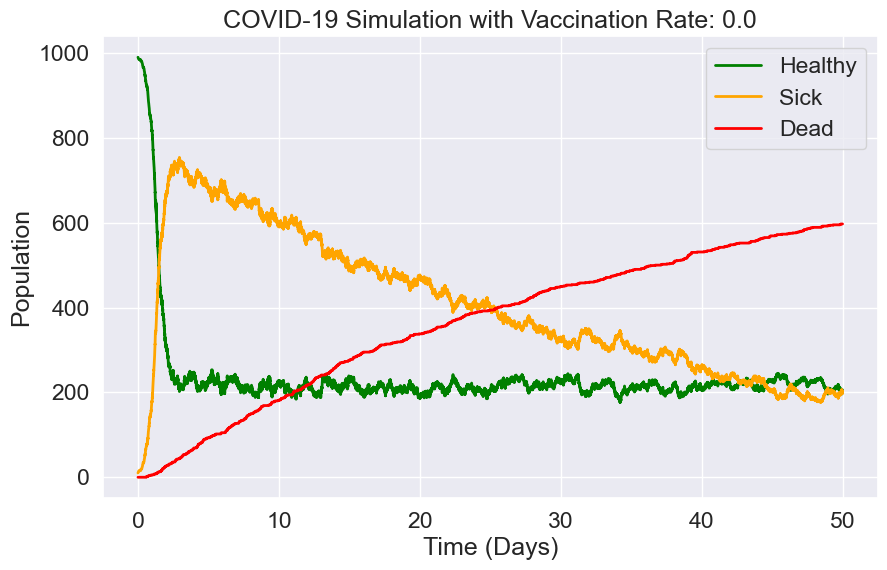

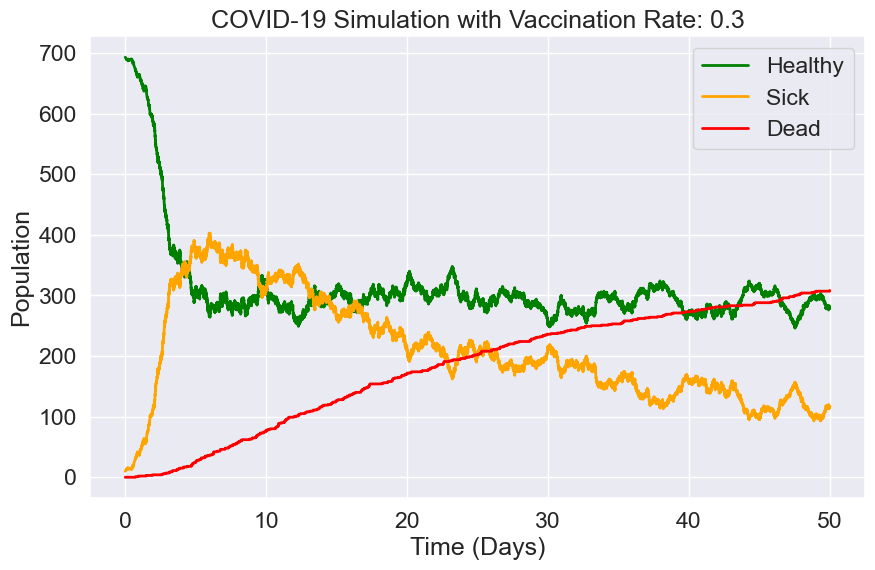

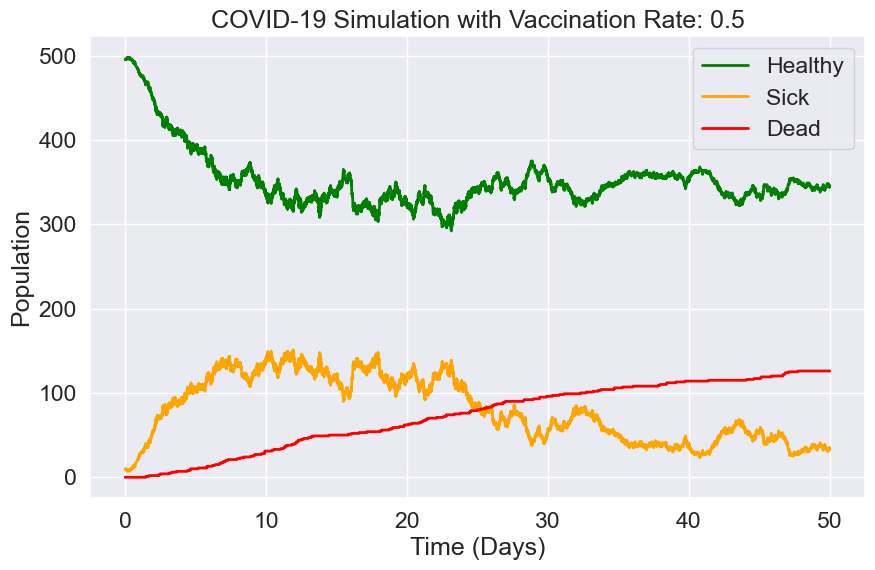

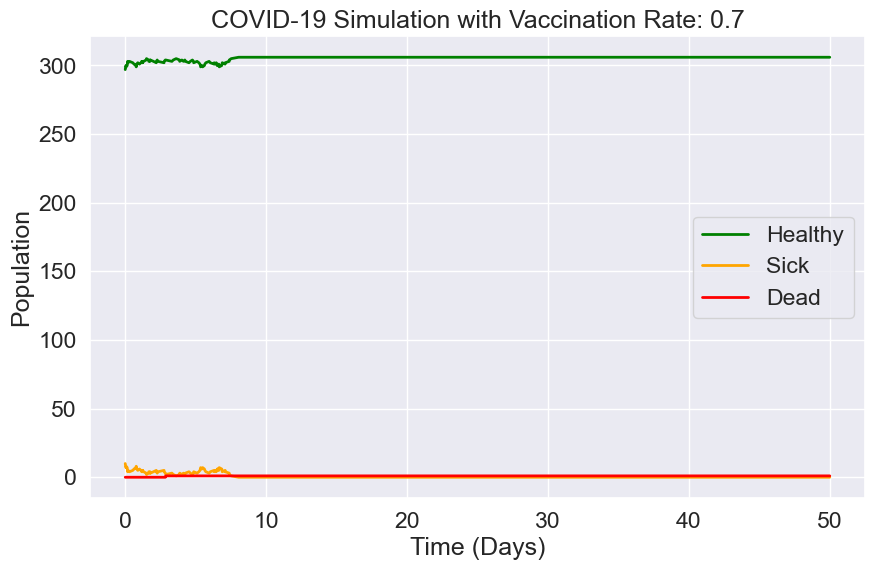

In [191]:
for vaccination_rate in vaccination_rates:
    times, healthy_trend, sick_trend, dead_trend = gillespie_disease_simulation(
        vaccination_rate, initial_healthy, initial_sick, initial_dead, max_time, recovery_rate, infection_rate, death_rate
    )
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(times, healthy_trend, label="Healthy", color="green")
    plt.plot(times, sick_trend, label="Sick", color="orange")
    plt.plot(times, dead_trend, label="Dead", color="red")
    plt.xlabel("Time (Days)")
    plt.ylabel("Population")
    
    # Corrected title formatting
    plt.title(f"COVID-19 Simulation with Vaccination Rate: {vaccination_rate}")
    
    plt.legend()
    plt.grid(True)
    plt.show()


### Discussion

The initial rise in sick individuals and the swift decline in healthy individuals reflect the behavior of a highly contagious virus within a closed, communal environment. This highlights how quickly a disease can spread in a confined population, particularly when there are no preventive measures in place. Upon introducing vaccination, the model shows a decrease in the number of individuals susceptible to infection, as the vaccine reduces the likelihood of falling ill. Furthermore, for those who do contract the disease, vaccination accelerates the recovery process, leading to a faster return to health.

While the results were generally in line with our expectations, there were some nuances. Initially, we anticipated a more gradual spread of the illness, but the model's rapid burst in cases made more sense upon further analysis. This pattern mirrors what was observed in the early stages of the COVID-19 pandemic, where the virus spread explosively due to the lack of social distancing and vaccinations. The sharp initial spike in cases underscores how quickly a virus can spread in the absence of immunity and preventive measures.

The results ultimately emphasize the dual benefits of vaccination: not only does it reduce the spread of the disease by lowering the number of susceptible individuals, but it also enhances recovery for those who do become infected. This highlights the critical importance of vaccination in controlling outbreaks and mitigating their impact on public health.

### Next Steps

First, we would expand the model to include more variables. To make the simulation more realistic and reflective of real-world scenarios, it would be beneficial to incorporate additional factors that influence disease spread. For instance, the model could account for the emergence of new virus strains, which may alter the transmission rates or the severity of the illness. Additionally, the impact of social distancing measures, lockdowns, and public health interventions could be integrated into the model to simulate how changes in behavior and policy affect disease dynamics. Another important factor to consider would be the capacity and responsiveness of healthcare systems, as this can significantly influence outcomes, especially in terms of treatment availability and recovery rates. By incorporating these factors, the model would provide a more comprehensive understanding of how different elements interact to affect the course of an outbreak.

Secondly, we would integrate real-world data. One of the most crucial improvements would be to update the model with real-time data, such as current COVID-19 case numbers, vaccination rates, and population demographics. By using up-to-date information, the model’s predictions would become more accurate and relevant to the present situation. This would not only help refine the model's ability to simulate disease spread but also provide insights into how different regions are responding to the pandemic. Real-time data would allow for a more dynamic and adaptable model that could provide more specific recommendations based on current trends. This approach could also reveal the effectiveness of public health measures over time, helping policymakers make informed decisions to mitigate future outbreaks.

Lastly, we would evaluate different vaccination strategies in order to determine what is best for the population. A critical aspect of controlling the spread of infectious diseases is the implementation of effective vaccination strategies. If more time were available, it would be valuable to test a variety of vaccination approaches to identify the most efficient methods for reducing the spread of disease. This could include experimenting with different vaccination rates, such as prioritizing high-risk populations first or gradually increasing vaccination coverage. Additionally, exploring the effects of vaccine hesitancy on overall vaccination rates would provide insight into how public attitudes influence the success of vaccination campaigns. By simulating various scenarios, we could identify the optimal vaccination strategies and understand their role in achieving herd immunity, reducing mortality rates, and controlling disease transmission in the broader community.



### How Feedback was Implemented

Initially, our group calculated the sick rate by dividing the number of active COVID-19 cases by the total number of confirmed cases within a country. While this method provided a rough estimate, it lacked context about the broader population size, which is critical for understanding the true scale of disease spread. After receiving feedback, we sought out additional datasets that included the population sizes of various countries. By merging this population data with the original dataset, we were able to refine our calculations. This integration allowed us to compute a more accurate infection rate, reflecting the proportion of the population currently infected rather than just the proportion of confirmed cases. The updated approach provided a more realistic picture of disease dynamics, enabling us to model the spread of infection more effectively across different vaccination scenarios.